In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import tensorflow as tf 
import keras

from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Dense, Dropout, Activation, Input, Flatten
from keras.utils import np_utils
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from sklearn.model_selection import train_test_split


2022-08-18 04:19:13.868822: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/majd/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# First Load the data

file_loc = '/home/majd/3D_sparse_tensors'

#Collect file names
files_sp = []
files_lb = []
for i in range(100):
    files_sp += ['/home/majd/3D_sparse_tensors'+'/sparse_recoils_'+str(i)+'.pt']
    files_lb += ['/home/majd/3D_sparse_tensors'+'/labels_'+str(i)+'.pt']
    
# Load data. X is a list of the sparse tensors and Y is a list of the corresponding true directions
X = []
Y = []

for sp,lb in zip(files_sp,files_lb):
    X += torch.load(sp)
    Y += np.loadtxt(lb).tolist()

# Note: a list of sparse tensors can not be converted into an array. A list of dense tensors can.


In [3]:
# Break into train and test sets
# There is no need to permute as they are already randomized 

split1 = int(0.6*len(X))
split2 = int(0.8*len(X))

X_train = X[:split1]
X_valid = X[split1:split2]
X_test = X[split2:]

Y_train = Y[:split1]
Y_valid = Y[split1:split2]
Y_test = Y[split2:]

print(len(X_train),len(X_valid),len(X_test))

480765 160255 160255


In [4]:
# data generator to yield both train and validation data.
# it takes ~0.36s to serve up a batch of 200  
def data_generator(X, Y, batchsize):
    N = len(X)
    while True:
        # We must use a for loop here as a list of sparse tensors may not be converted into an array
        indices = np.random.randint(low=0, high=N, size=(batchsize,))
        X1 = np.array( [(X[index].to_dense()).detach().numpy() for index in indices] )
        Y1 = np.array( [Y[index] for index in indices] )
        
        # yield tensors and directions
        yield X1, Y1
        
# Create generators.
batchsize  = 150
data_train = data_generator(X_train, Y_train, batchsize)
data_valid = data_generator(X_valid, Y_valid, batchsize)

In [5]:
# inputs, outputs = data_train.__next__()

# print(inputs.shape)
# print(outputs.shape)

In [6]:
def cust_act(x):
    return tf.keras.backend.l2_normalize(x, axis=1)

In [7]:
# Creat agent with keras

class Agent():
    
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07):
        # Define CNN architecture here
        # We will use a sequential model
        self.model = Sequential()
        
        # Start with Convolutional Layer and max pooling     
        self.model.add(Conv3D(50, kernel_size=(6,6,6), strides=(2,2,2), padding = 'same', activation='relu', input_shape=(120, 120, 120, 1)))
        self.model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        self.model.add(Conv3D(30, kernel_size=(4,4,4), strides=(1,1,1), padding = 'same', activation='relu'))        
        self.model.add(Conv3D(20, kernel_size=(3,3,3), strides=(1,1,1), padding = 'same', activation='relu'))
        
        self.model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        # Flatten the data
        self.model.add(Flatten())
        
        # Dense Layer
        self.model.add(Dense(100, activation='relu'))
        
        self.model.add(Dense(30, activation='tanh'))
        
        # Output Layer
        self.model.add(Dense(3, activation=cust_act))
        
        # Print CNN architecture summary
        self.model.summary()
        
        # Specificy the optimizer
        opt=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, amsgrad=False, name="adam")
        
        # Initialize model
        self.model.compile(loss=tf.keras.losses.CosineSimilarity(axis=1), optimizer=opt)


    def train(self, data_train,data_valid):
        
        # Implement early stopping to avoild overfitting
        stopping  = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')
        callbacks = [stopping]
        
        # train the model
        history = self.model.fit_generator(generator=data_train, steps_per_epoch=100, epochs=200, verbose=1, callbacks=callbacks, validation_data=data_valid, validation_steps=100)
        
        return history

    def predict(self,images):
                
        # predict initial direction
        pred = self.model.predict(images)
        
        return pred



In [9]:
# Create agent object
agent = Agent(learning_rate=0.001, beta_1=0.94, beta_2=0.999, epsilon=1e-07) #Specify Optimizer hyperparameters

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 60, 60, 60, 50)    10850     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 30, 30, 30, 50)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 30, 30, 30, 30)    96030     
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 30, 30, 30, 20)    16220     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 15, 15, 15, 20)    0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)              

In [10]:
# Train the agent
history = agent.train(data_train,data_valid)

/home/majd/.conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-08-18 04:21:26.580976: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-18 04:21:26.581467: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/200


2022-08-18 04:21:26.967924: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-18 04:21:27.335013: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-08-18 04:21:27.335151: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-08-18 04:21:30.067837: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-18 04:21:31.047712: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


100/100 [==============================] - 200s 2s/step - loss: -0.2798 - val_loss: -0.3565
Epoch 2/200
100/100 [==============================] - 164s 2s/step - loss: -0.4125 - val_loss: -0.4568
Epoch 3/200
100/100 [==============================] - 164s 2s/step - loss: -0.4647 - val_loss: -0.5013
Epoch 4/200
100/100 [==============================] - 164s 2s/step - loss: -0.5126 - val_loss: -0.5054
Epoch 5/200
100/100 [==============================] - 164s 2s/step - loss: -0.5891 - val_loss: -0.6695
Epoch 6/200
100/100 [==============================] - 164s 2s/step - loss: -0.6815 - val_loss: -0.7159
Epoch 7/200
100/100 [==============================] - 163s 2s/step - loss: -0.7376 - val_loss: -0.7442
Epoch 8/200
100/100 [==============================] - 163s 2s/step - loss: -0.7657 - val_loss: -0.7968
Epoch 9/200
100/100 [==============================] - 164s 2s/step - loss: -0.8076 - val_loss: -0.8115
Epoch 10/200
100/100 [==============================] - 163s 2s/step - loss:

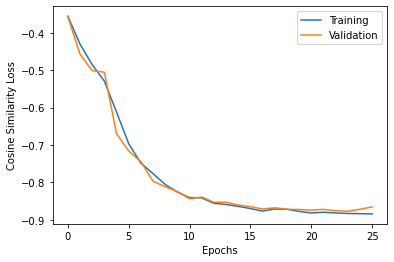

In [11]:
# Plot loss trajectory throughout training.
plt.figure()
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Cosine Similarity Loss')
plt.legend()

# Validation loss does not increase, so we are not overfitting

In [36]:
# Obtain test set, for now I onluy use 10000 simulations form the test set
data_test = data_generator(X_test, Y_test, 100)

inputs_test, outputs_test = data_test.__next__()
inputs_test.shape

(100, 120, 120, 120, 1)

In [37]:
# Predict initial directions for test set
output_pred = agent.predict(inputs_test)

In [38]:
# Compute angles between predicted direction and true direction
angs = []
for v1,v2 in zip(output_pred,outputs_test):
    angs += [np.arccos(np.dot(v1,v2))*180/np.pi]
    
print( "mean = ", np.mean(angs) )

mean =  21.949571104366186


In [39]:
# calculate RMS 
angs =np.array(angs)

print("RMS = ", np.sqrt(angs.dot(angs)/len(angs)) )
# compare to the predicted best achievable 

RMS =  26.682532263993426
